In [1]:
import paths as paths
import shared.locals as locals
from datetime import datetime, timedelta
from helpers.config import Configuration
from database.database import Database
from database.models import Commit, ErrorLog

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

start_date = datetime.utcfromtimestamp(config.start_timestamp)
limit_date = datetime.utcfromtimestamp(config.limit_timestamp)

delta = limit_date - start_date
days = [(start_date+timedelta(days=i)).date() for i in range(delta.days + 1)]
years = {day.year for day in days}

activity_result = {year: {day: 0 for day in days if day.year == year} for year in years}
for commit in database.all(Commit.LABEL):
    date = datetime.utcfromtimestamp(commit.timestamp).date()
    activity_result[date.year][date] += 1

error_result = {year: {day: {"development": 0, "production": 0} 
    for day in days if day.year == year} for year in years}
for errorlog in database.all(ErrorLog.LABEL):
    date = datetime.utcfromtimestamp(errorlog.timestamp).date()
    error_result[date.year][date][errorlog.account] += 1

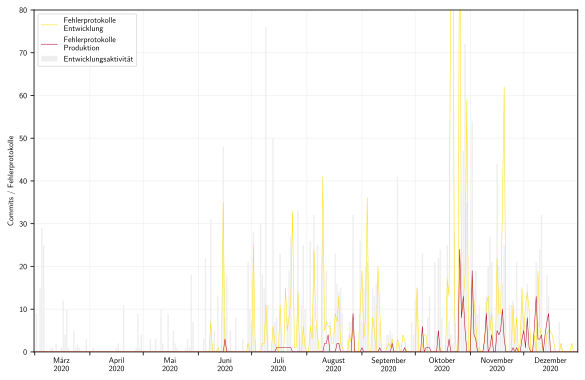

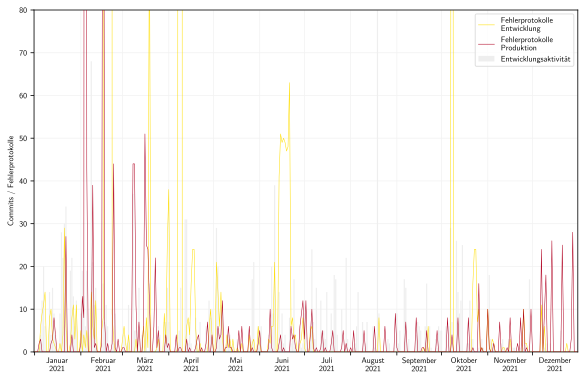

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)

for year in years:
    fig, ax = plt.subplots(figsize=(locals.TEXTHEIGHT, locals.TEXTWIDTH * 0.9))

    dates = list(error_result[year].keys())
    error_result_prod = [result["production"] for result in error_result[year].values()]
    error_result_dev = [result["development"] for result in error_result[year].values()]

    # Erstellung des Entwicklungsaktivität-Graphen
    ax.bar(dates, list(activity_result[year].values()), color=locals.BACKGROUND_GRAY,
        label="Entwicklungsaktivität", zorder=1)

    # Erstellung der Fehler-Graphen
    ax.plot(dates, error_result_dev, color=locals.ERROR_COLLOR_YELLOW,
        label="Fehlerprotokolle\nEntwicklung", zorder=2, linewidth=0.5)

    ax.plot(dates, error_result_prod, color=locals.ERROR_COLOR_RED,
        label="Fehlerprotokolle\nProduktion", zorder=3, linewidth=0.5)

    # Formatierung der Ausgabe
    ax.legend(loc="upper left" if year != 2021 else "upper right", edgecolor=locals.FRAME_GRAY)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(mticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%B\n%Y"))
    ax.tick_params(axis="x", which="minor", bottom=False, top=False, labelbottom=True)

    ax.margins(x=0)
    ax.set_ylabel("Commits / Fehlerprotokolle")
    ax.set_ylim([0,80])
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=10))
    ax.grid(color=locals.GRID_GRAY)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()